In [8]:
from lpshg import LPSHGsim

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
# 2D Gaussian
def gauss2D(xx, yy, wx, wy, order=1, width="FWHM"):
    if width == "FWHM":
        wx = wx / (2 * np.sqrt(2 * np.log(2)))
        wy = wy / (2 * np.sqrt(2 * np.log(2)))
    else:
        wx = wx
        wx = wx
    return np.exp(-((xx**2 / (2*wx**2)) + yy**2 / (2*wy**2))**order)

# 1D Gaussian
def gauss1D(xx, wx, order=1, width="FWHM"):
    if width == "FWHM":
        wx = wx / (2 * np.sqrt(2 * np.log(2)))
    else:
        wx = wx
    return np.exp(-((xx**2 / (2*wx**2)))**order)

In [10]:
# Define spatial grid
X = 10e-3 # size of grid in x
Nx = 64   # number of grid points in x
Y = 10e-3 # size of grid in y
Ny = 64   # number of grid points in y

x = np.linspace(-X/2, X/2, Nx+1)[:-1]
y = np.linspace(-Y/2, Y/2, Ny+1)[:-1]
XX, YY = np.meshgrid(x,y)

dx = x[1]-x[0]
dy = y[1]-y[0]

# define temporal grid
T = 150e-9
Nt = 32
t = np.linspace(-T/2, T/2, Nt+1)[:-1]
dt = T/Nt

# spatial profile
wx = 2e-3 # FWHM beamsize in x [m] 
wy = 2e-3 # FWHM beamsize in y [m]
I_space = gauss2D(XX, YY, wx, wy, order=1) 

# temporal profile
tau = 30e-9 # FWHM pulse duration [s]
I_time = gauss1D(t, tau, order=1) 

# Pulse energy
E_pulse = 1.0 # [J]

# combine spatial and temporal profile to 3D intensity profile
I = I_space[:,:,None]*I_time[None,None,:]
I *= E_pulse / np.sum(I) /dx/dx/dt

print('Peak intensity: {:.2f}GW/cm^2'.format(np.max(I)*1e-13))

Peak intensity: 0.69GW/cm^2


In [11]:
sim = LPSHGsim(I, X, Y, T, xtal_length=30e-3)
sim.Nx = Nx
sim.Ny = Nx
sim.Nt = len(t)
sim.Nz = 500

In [12]:
sim.run()

Text(0.5, 0, 'z [m]')

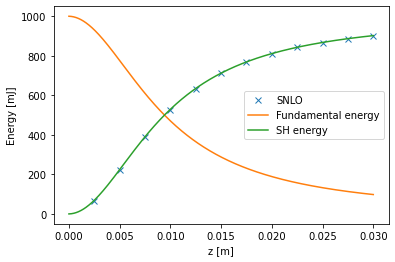

In [13]:
SNLO_z = np.array([2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30])*1e-3
SNLO_E = np.array([66.3, 221, 387, 527, 633, 711, 768, 810, 842, 866, 885, 900])

plt.plot(SNLO_z, SNLO_E, 'x', label='SNLO')
plt.plot(sim.z, 1e3*np.array(sim.energy_fund), label='Fundamental energy')
plt.plot(sim.z, 1e3*np.array(sim.energy_shg), label='SH energy')
plt.legend()
plt.ylabel('Energy [mJ]')
plt.xlabel('z [m]')
#plt.grid()

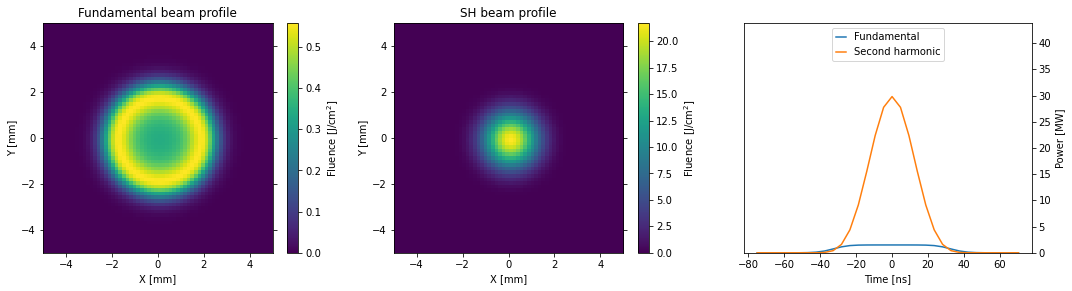

In [14]:
I_fund, I_shg = sim.get_intensies()

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

col1 = ax[0].imshow(
    np.sum(I_fund, axis=-1) * dt * 1e-4,
    aspect="equal",
    extent=(-X / 2 * 1e3, X / 2 * 1e3, -Y / 2 * 1e3, Y / 2 * 1e3),
)
fig.colorbar(col1, ax=ax[0], label="Fluence [J/cm$^2$]")

col2 = ax[1].imshow(
    np.sum(I_shg, axis=-1) * dt * 1e-4,
    aspect="equal",
    extent=(-X / 2 * 1e3, X / 2 * 1e3, -Y / 2 * 1e3, Y / 2 * 1e3),
)

fig.colorbar(col2, ax=ax[1], label="Fluence [J/cm$^2$]")

dx = sim.dx
dy = sim.dy
ax[2].plot(t * 1e9, np.sum(I_fund, axis=(0, 1)) * dx * dy * 1e-6, label="Fundamental")
ax[2].plot(
    t * 1e9, np.sum(I_shg, axis=(0, 1)) * dx * dy * 1e-6, label="Second harmonic"
)
ax[2].legend(handlelength=1, loc="upper center")
ax[2].set_ylim(0, ax[2].get_ylim()[1] * 1.4)
ax[2].set_xlabel("Time [ns]")
ax[2].set_ylabel("Power [MW]")
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.set_ticks_position("right")


ax[0].set_xlabel("X [mm]")
ax[0].set_ylabel("Y [mm]")
ax[0].yaxis.set_ticks_position("both")
ax[1].set_xlabel("X [mm]")
ax[1].set_ylabel("Y [mm]")
ax[1].yaxis.set_ticks_position("both")

ax[0].set_title("Fundamental beam profile")
ax[1].set_title("SH beam profile")

fig.tight_layout()